In [1]:
import os
import cv2
import json
import glob
import threading
import warnings
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.exceptions import ConvergenceWarning

# Parse data path

In [2]:
keyframes_dir = r'D:\VN_Multi_User_Video_Search\frontend\ai\public\data\Keyframes'
all_keyframe_paths = dict()
for folder_name in sorted(os.listdir(keyframes_dir)):
    folder_path = os.path.join(keyframes_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name.endswith('.mp4') is False:
        # Tên folder là Lxx_Vxxx
        data_part, video_id = folder_name.split('_')
        if data_part not in all_keyframe_paths:
            all_keyframe_paths[data_part] = dict()
        keyframe_paths = sorted(glob.glob(f'{folder_path}/*.jpg'))
        all_keyframe_paths[data_part][video_id] = keyframe_paths

# Color


Custom Pallete


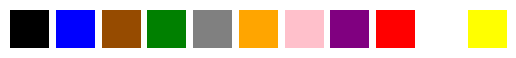

In [3]:
color_pallette ={
    'black' :  [0, 0, 0],
    'blue'  :  [0, 0, 255],
    'brown' :  [150, 75, 0],
    'green' :  [0, 128, 0],
    'grey'  :  [128, 128, 128],
    'orange':  [255, 165, 0],
    'pink'  :  [255, 192, 203],
    'purple':  [128, 0, 128],
    'red'   :  [255, 0, 0],
    'white' :  [255, 255, 255],
    'yellow':  [255, 255, 0]
}

n_colors = len(color_pallette)

print("Custom Pallete")
plt.figure(0)
for i, (_, value)  in enumerate(color_pallette.items()):
    patch = np.ones((20, 20, 3), dtype=np.uint8)
    patch[:, :, :] = value
    plt.subplot(1, n_colors, i+1)
    plt.axis('off')
    plt.imshow(patch)
plt.show()     

# Helper Function

In [4]:
class VisualEncoding:
  def __init__(self,
                classes = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
                           'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
                           'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                           'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
                           'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
                           'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                           'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
                           'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
                           'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                           'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
                           'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
                           'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                           'scissors', 'teddy bear', 'hair drier', 'toothbrush'),
                colors = ('black', 'blue', 'brown', 'green', 'grey', 'orange_', 'pink', 'purple',
                          'red', 'white', 'yellow'),
                row_str = ["0", "1", "2", "3", "4", "5", "6"],
                col_str = ["a", "b", "c", "d", "e", "f", "g"]):
    self.classes = classes
    self.colors = colors
    self.classes2idx = dict()
    for i, class_ in enumerate(classes):
      self.classes2idx[class_] = i
    self.n_row = len(row_str)
    self.n_col = len(col_str)

    x_pts = np.linspace(0, 1, self.n_row+1)
    y_pts = np.linspace(0, 1, self.n_col+1)

    self.grid_bboxes = []
    self.grid_labels = []
    for i in range(self.n_row):
      for j in range(self.n_col):
        label = col_str[j] + row_str[i]
        self.grid_bboxes.append([x_pts[j], y_pts[i], x_pts[j+1], y_pts[i+1]])
        self.grid_labels.append(label)

    self.grid_bboxes = np.array(self.grid_bboxes)

In [5]:
def match_image_to_pallete(image_colors, pallete_colors, threshold = 0.07):
    #converts RGB to CIE 1976 L*a*b values. The CIELAB color space
    #(also known as CIE L*a*b*) is a color space defined by the
    #International Commission on Illumination (CIE) in 1976.
    h, w, _ = image_colors.shape
    n_pixels = h*w

    image_colors = rgb2lab(np.uint8(np.asarray(image_colors))).reshape(-1, 1, 3)
    pallete_colors = rgb2lab(np.uint8(np.asarray([pallete_colors]))).reshape(-1, 3)

    #Euclidean distance between two points in Lab color space.
    diff = deltaE_cie76(image_colors, pallete_colors)
    color_indices, color_frequencies = np.unique(np.argsort(diff)[:, :2].reshape(-1), return_counts=True)
    color_indices = color_indices[color_frequencies > n_pixels*threshold]
    return color_indices

In [6]:
encoder = VisualEncoding()
grid_bboxes = encoder.grid_bboxes
grid_labels = encoder.grid_labels
color_pallette_lst = list(color_pallette.values())
id2colors = [key for key in color_pallette.keys()]

# Run inference

In [7]:
def thread_helper(i, image, h, w):
    x0, y0, x1, y1 = grid_bboxes[i]
    x0, y0, x1, y1 = int(x0*w), int(y0*h), int(x1*w), int(y1*h)
    crop_image = image[y0:y1, x0:x1, :]
    color_indices = match_image_to_pallete(crop_image, color_pallette_lst)
    for color_idx in color_indices:
        context.append(grid_labels[i] + id2colors[color_idx])

In [9]:
save_dir_all = 'context_encoded'
save_dir = os.path.join(save_dir_all, 'colors_encoded')
os.makedirs(save_dir, exist_ok=True)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

for key, video_keyframe_paths in all_keyframe_paths.items():
    out_key_dir = os.path.join(save_dir, key); os.makedirs(out_key_dir, exist_ok=True)

    for video_id in sorted(video_keyframe_paths.keys()):
        keyframes = video_keyframe_paths[video_id]
        out_path  = os.path.join(out_key_dir, f"{video_id}.txt")
        if os.path.exists(out_path):  # bỏ qua nếu đã có
            continue

        video_color_contexts = []
        for image_path in keyframes:
            img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # H×W×3 (uint8)
            if img is None: 
                video_color_contexts.append(""); continue

            # to tensor on GPU
            t = torch.from_numpy(img).to(device=device, dtype=torch.float32)  # H×W×3
            t = t.permute(2,0,1) / 255.0                                     # 3×H×W

            # tính context theo grid_bboxes: [(x1,y1,x2,y2), ...]
            vals = []
            for x1,y1,x2,y2 in grid_bboxes:
                patch = t[:, int(y1):int(y2), int(x1):int(x2)]
                if patch.numel() == 0:
                    vals += [0,0,0]; continue
                m = patch.mean(dim=(1,2))          # 3 kênh
                vals += [float(m[0]), float(m[1]), float(m[2])]
            video_color_contexts.append(" ".join(map(str, vals)))

        # kiểm tra & ghi
        if len(video_color_contexts) != len(keyframes):
            print("Something wrong!!!!!"); break
        with open(out_path, "w", encoding="utf-8") as f:
            f.write("\n".join(video_color_contexts))
